In [38]:
import numpy as np
import matplotlib as mpl
mpl.use('Agg')

import geopandas as gpd
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy.io.img_tiles import Stamen
import cartopy.io.shapereader as shpreader
import matplotlib.ticker as mticker
from matplotlib.patches import Circle

from matplotlib import gridspec
import time 
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp
from pingouin import partial_corr

from demo import *
from demo_backup import *

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

coastline = gpd.read_file('/home/mizu_home/xp53/nas_home/coastlines-split-SGregion/lines.shp')
mask = np.loadtxt('mask.txt')

ipcc_blue = (112.0/255, 160.0/255, 205.0/255, 1.0)
ipcc_orange = (196.0/255, 121.0/255, 0.0/255, 1.0)

In [10]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [11]:
# DATA PREPARATION
# the station-based rainfall data is already organized in a N by P matrix
rain_obs = np.loadtxt('data/sta_monthly.csv')

# the simulated rainfall data is reshaped to a 2d matrix of size N by (W x L)
rain_sim_flatten = np.loadtxt('data/wrf_monthly.csv')
rain_sim = rain_sim_flatten.reshape(rain_sim_flatten.shape[0], 120, 160)

# sim_sel constains a P by 4 matrix
# the first two columns are the row and column indices of grids corresponding to the stations
# the last two columns are the lons and lats of grids corresponding to the stations
sim_sel = np.loadtxt('data/wrf_loc.csv')
sim_idx = sim_sel[:, :2].astype(int)

# select simulated rainfall at stations
wrf_sta = np.array([rain_sim[:, i, j] for (i, j) in sim_idx]).T

# lats and lons of all grids are stored in a 2d matrix of 2 by (W x L)
# the first row is lons and the second row is lats
longlat = np.loadtxt('data/lonlat.txt')
lons = longlat[0, :].reshape(120, 160)
lats = longlat[1, :].reshape(120, 160)

# read station lons (3rd column) and lats (4th column)
sta_loc = np.genfromtxt('data/sta_lookup_new.csv', delimiter=',')[:, 2:]

# read wrf simulated rainfall forced by cmip6 future climate
cmip_rain_f = np.loadtxt('data/wrf_monthly_cmip.txt')[-40:, :]
cmip_rain0 = cmip_rain_f.reshape(cmip_rain_f.shape[0], 12, 120, 160)
cmip_rain = np.zeros(cmip_rain0.shape)
cmip_rain[:, 0:6, :, :] = cmip_rain0[:, 6:12, :, :]
cmip_rain[:, 6:12, :, :] = cmip_rain0[:, 0:6, :, :]
wrf_sta_fut = np.array([cmip_rain[:, :, i, j] for (i, j) in sim_idx]).T


In [12]:
tmp1 = gp_interpolator(P = sim_idx.shape[0] - 1)
kge0 = np.zeros((12, tmp1.p_ + 1))
kge1 = np.zeros((12, tmp1.p_ + 1))

for i in range(12):
    xx_obs = rain_obs[i::12, :]
    xx_sim = wrf_sta[i::12, :]
    for j in range(tmp1.p_ + 1):
        txx_obs = np.delete(xx_obs, j, axis = 1)
        txx_sim = np.delete(xx_sim, j, axis = 1)
        tmp1.read_rainfall(obs = txx_obs, sim = txx_sim)
        tmp1.sn_converge()
        yy_sim = xx_sim[:, j][:, None]
        yy_obs = xx_obs[:, j][:, None]
        yy_fit, _ = tmp1.predict(yy_sim)
        yy_fit[yy_fit < 0] = 0 
        kge0[i, j] = kge(yy_obs.squeeze(), yy_sim.squeeze())
        kge1[i, j] = kge(yy_obs.squeeze(), yy_fit.squeeze())

''

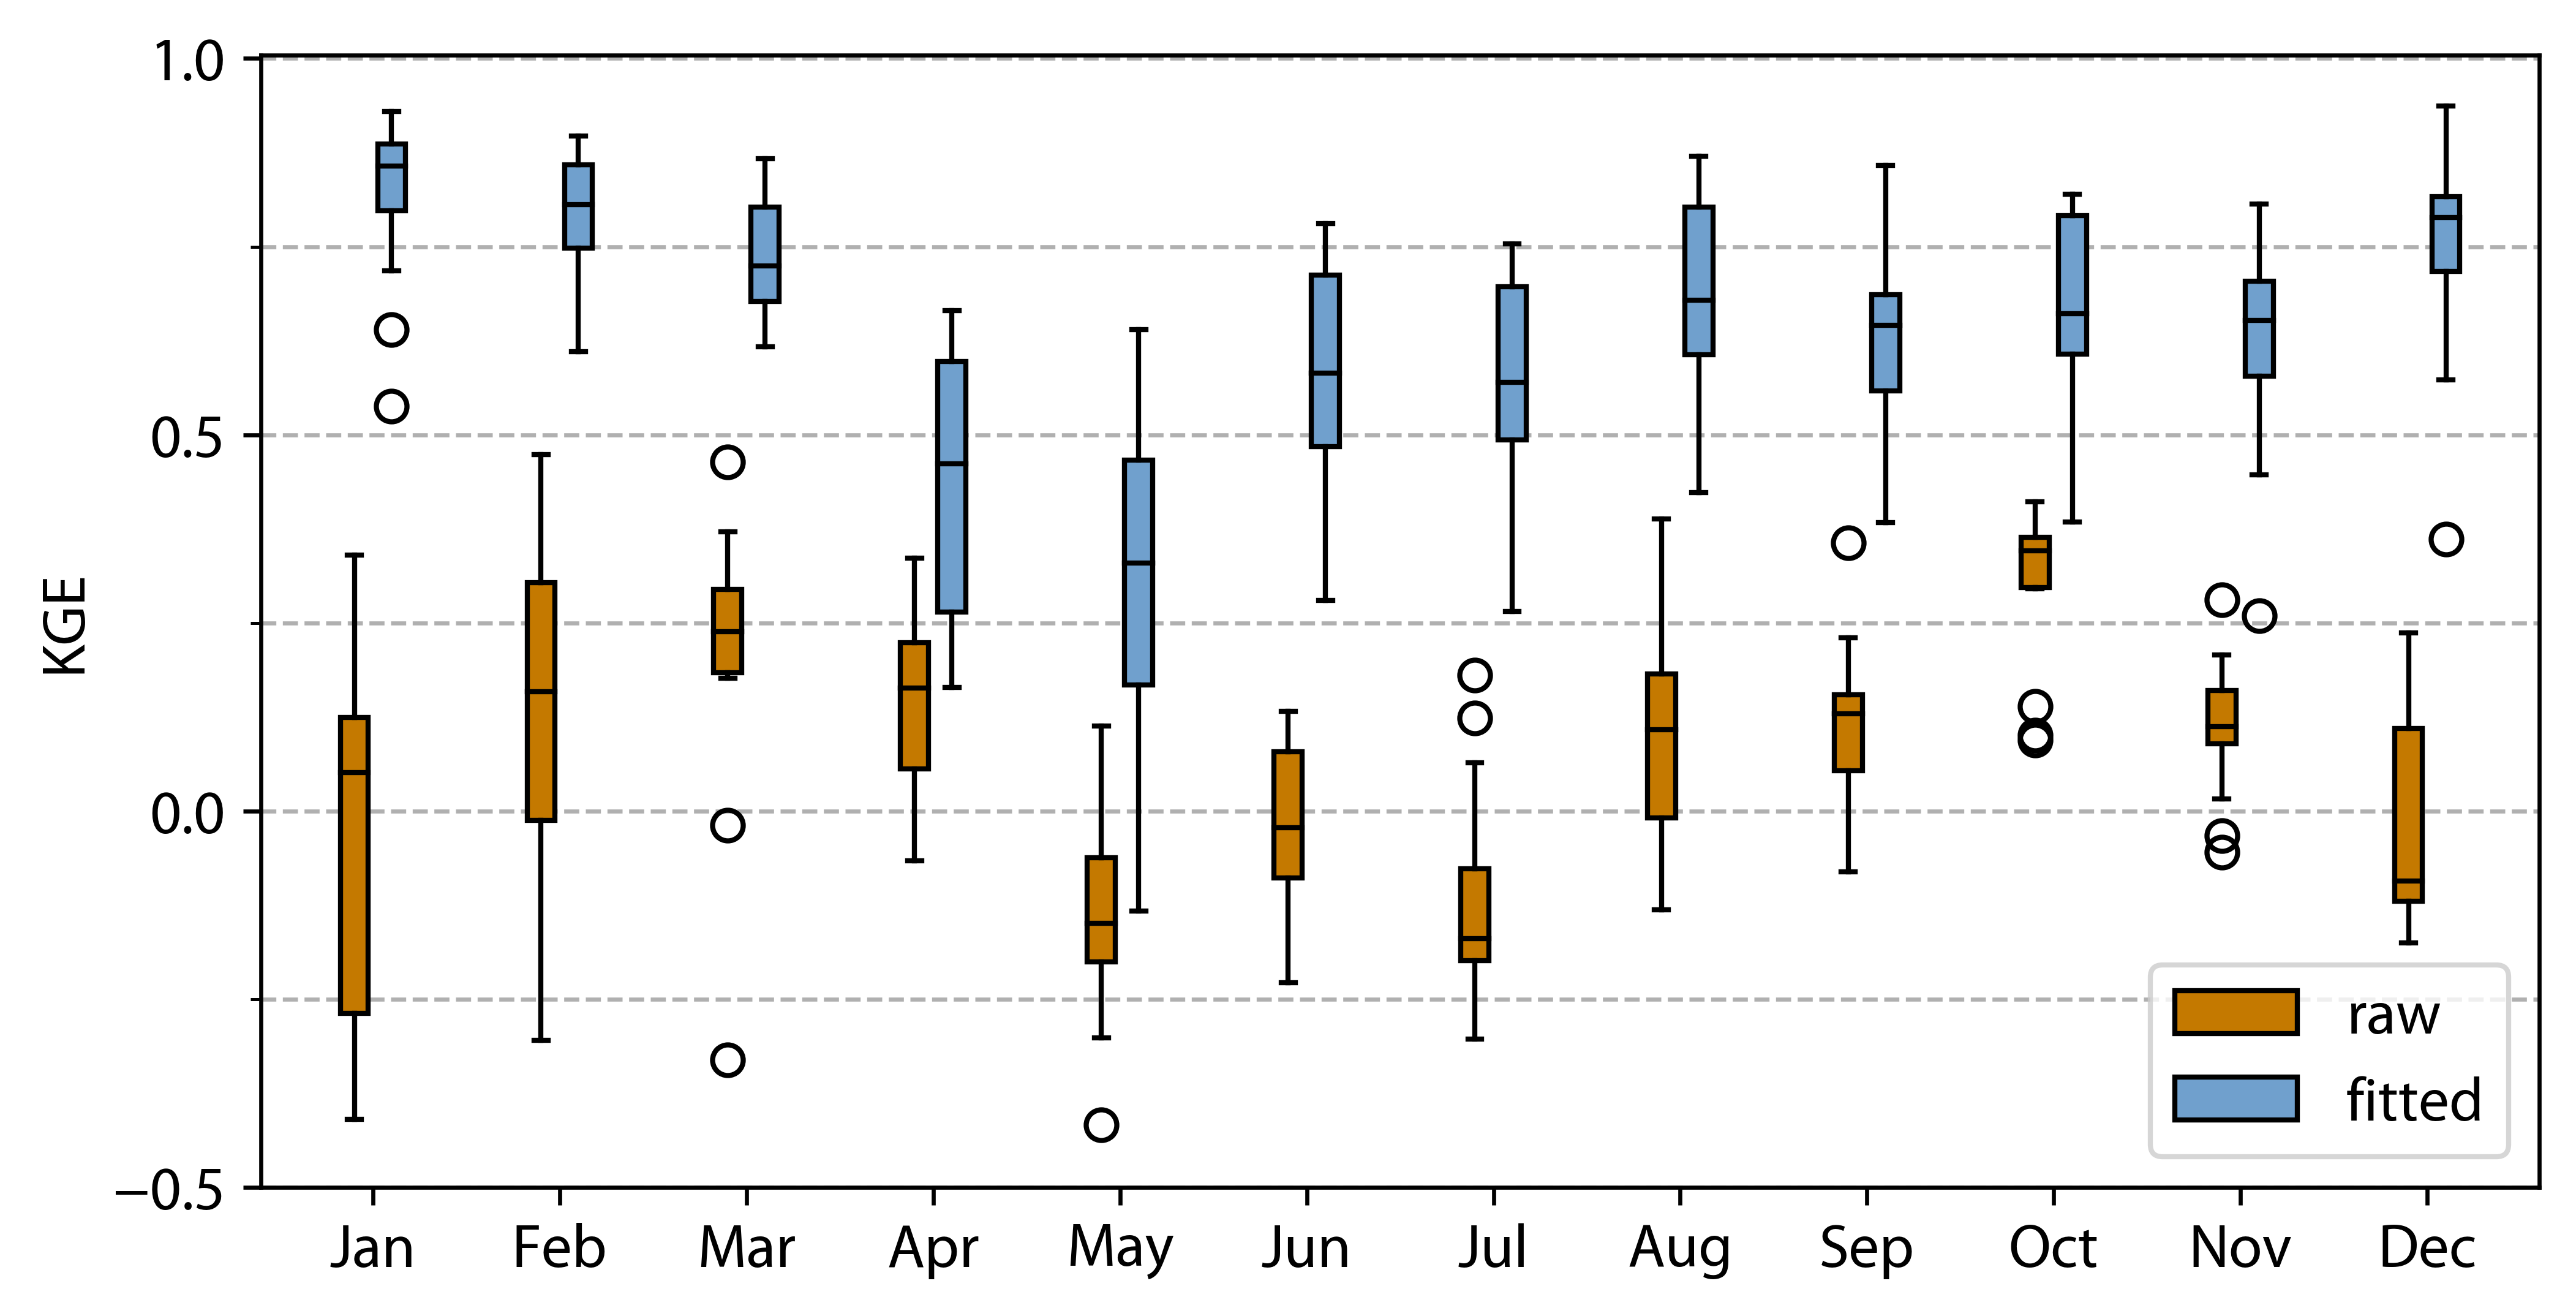

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (8, 4))
# plot the kge0 boxplot at positions of x with filler color of red
bp1 = ax.boxplot(kge0.T, positions = np.arange(12) - 0.1, widths = 0.15,
           patch_artist = True, boxprops=dict(facecolor=ipcc_orange), medianprops=dict(color="black"))
bp2 = ax.boxplot(kge1.T, positions = np.arange(12) + 0.1, widths = 0.15,
           patch_artist = True, boxprops=dict(facecolor=ipcc_blue), medianprops=dict(color="black"))
ax.set_xticks(np.arange(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('KGE')
ax.set_yticks([-0.5, 0, 0.5, 1])
# set minor ticks on y axis with an interval of 0.25
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))
ax.grid(which = 'both', axis = 'y', linestyle = '--')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['raw', 'fitted'])
;

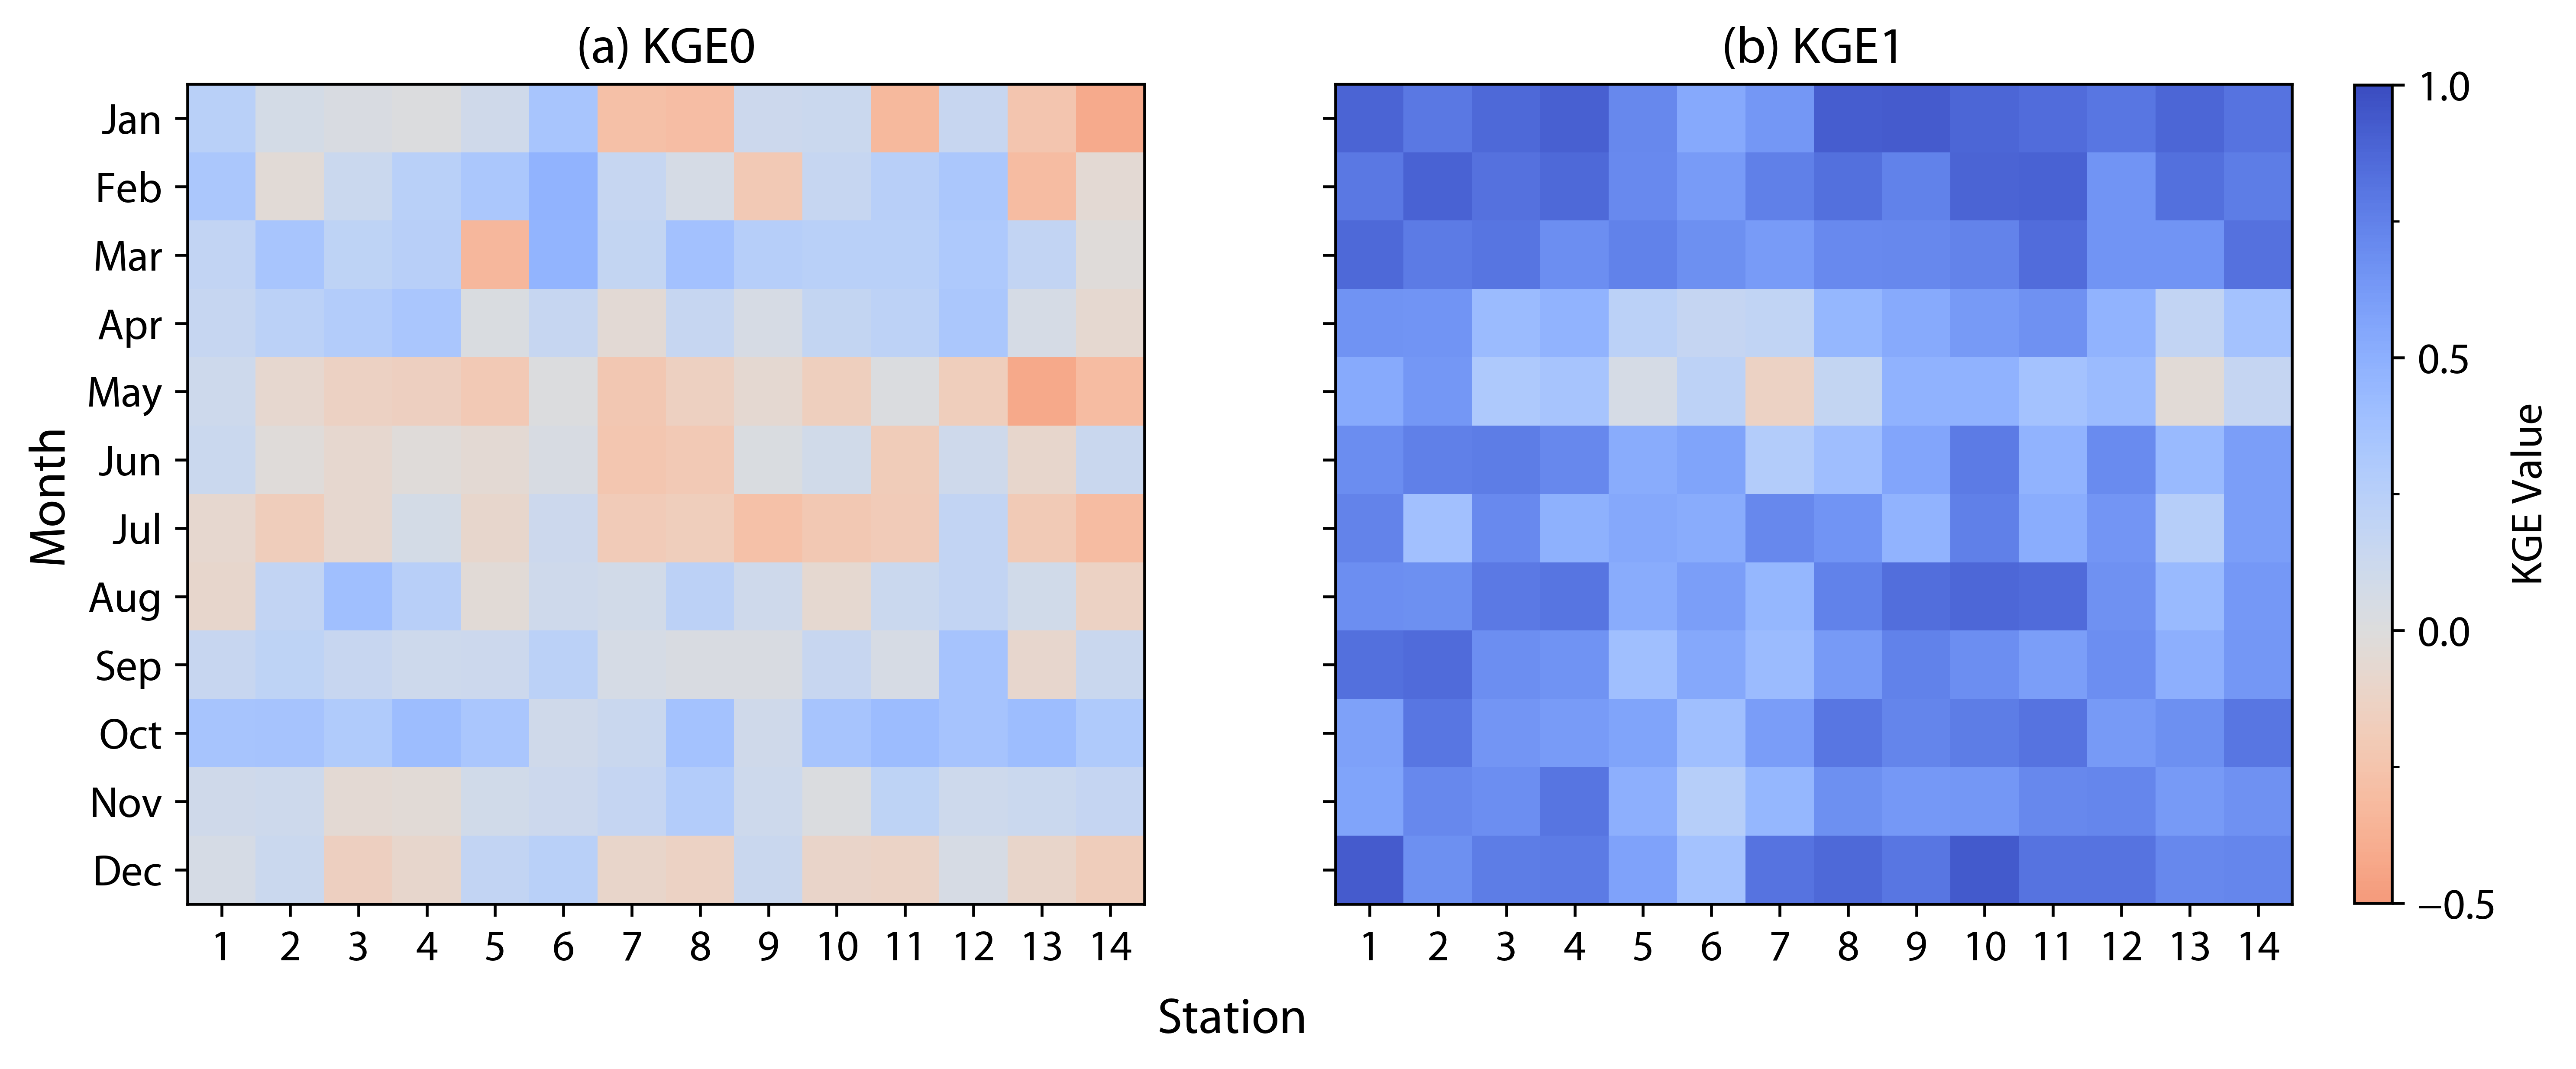

''

In [20]:
# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
mpl.rcParams.update({'font.size': 12})
# Define the colormap and normalization
cmap = 'coolwarm_r'
norm = MidpointNormalize(vmin=-0.5, vmax=1, midpoint=0)

# Plotting KGE0
img0 = ax[0].imshow(kge0, cmap=cmap, norm=norm)  # Transpose array for correct orientation
ax[0].set_xticks(np.arange(14))
ax[0].set_xticklabels(np.arange(1, 15))
ax[0].set_yticks(np.arange(12))
ax[0].set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[0].set_ylabel('Month', fontsize = 14)
ax[0].set_title('(a) KGE0')

# Plotting KGE1
img1 = ax[1].imshow(kge1, cmap=cmap, norm=norm)  # Transpose array for correct orientation
ax[1].set_xticks(np.arange(14))
ax[1].set_xticklabels(np.arange(1, 15))
ax[1].set_title('(b) KGE1')

# Set a common x-label
fig.text(0.46, 0.06, 'Station', ha='center', va='center', fontsize = 14)

# Adjust layout to leave space for colorbar
fig.subplots_adjust(right=0.8, bottom=0.05)

# Create a colorbar with the correct positioning
cbar_ax = fig.add_axes([0.82, 0.15, 0.012, 0.63])  # Adjust the colorbar to match subplot height
cbar = fig.colorbar(img1, cax=cbar_ax)
cbar.set_label('KGE Value')

# Set major and minor ticks on the colorbar
cbar.set_ticks([-0.5, 0, 0.5, 1])
cbar.ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))

plt.show()
;

In [ ]:
path = 'figures_new/scatter_plots/'
str = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
for i in range(12):
    xx_obs = rain_obs[i::12, :]
    xx_sim = wrf_sta[i::12, :]
    fig, ax = plt.subplots(4, 4, figsize=(12, 12), sharex=True, sharey=True)
    for j in range(14):  # Plot only for 14 stations
        ri, ci = divmod(j, 4)  # Calculate row, column index
        txx_obs = np.delete(xx_obs, j, axis=1)
        txx_sim = np.delete(xx_sim, j, axis=1)
        tmp1.read_rainfall(obs=txx_obs, sim=txx_sim)
        tmp1.sn_converge()
        yy_sim = xx_sim[:, j][:, None]
        yy_obs = xx_obs[:, j][:, None]
        yy_fit, _ = tmp1.predict(yy_sim)
        yy_fit[yy_fit < 0] = 0
        ax[ri, ci].scatter(yy_obs, yy_sim, color=ipcc_orange, marker='D', s=20, label='raw')
        ax[ri, ci].scatter(yy_obs, yy_fit, color=ipcc_blue, marker='o', s=20, label='fitted')
        ax[ri, ci].axline([0, 0], [1, 1], color='black', linestyle='--')
        tmp_kge1 = kge(yy_obs.squeeze(), yy_fit.squeeze())
        tmp_kge0 = kge(yy_obs.squeeze(), yy_sim.squeeze())
        ax[ri, ci].set_title('(' + str[j] + f') KGE = {tmp_kge1:.2f} ({tmp_kge0:.2f})')
        ax[ri, ci].set_xlim(left=0)  # Set x-axis to start from 0
        ax[ri, ci].set_ylim(bottom=0)  # Set y-axis to start from 0
    
    # Hide unused subplots
    for k in range(14, 16):
        ax[k // 4, k % 4].axis('off')

    ax[2, 2].tick_params(axis='x', which='both', labelbottom=True)  # Figure (k)
    ax[2, 3].tick_params(axis='x', which='both', labelbottom=True)  # Figure (l)

    # Place a single legend on the last row's leftmost subplot
    handles, labels = ax[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.6, 0.1), fontsize = 14)

    # Add shared x and y axis labels
    fig.text(0.5, 0.01, 'Observed Rainfall [mm]', ha='center', va='center', fontsize='large')
    fig.text(0.01, 0.5, 'Estimated Rainfall [mm]', ha='center', va='center', rotation='vertical', fontsize='large')

    plt.subplots_adjust(left=0.12, right=0.9, top=0.9, bottom=0.12)  # Adjust the subplots to provide space for labels
    plt.tight_layout(pad=2)  # Increase padding to avoid overlap
    plt.show()

    fig.savefig(f'{path}scatter_{i+1}.pdf')
    plt.close(fig)
;

in our context, the sn var measures the mismatch between the rainfall at the pixel and the corresponding observational rainfall.

To better understand its effect on the performance of the rainfall interpolation: suppose we can fix everything and only manuver the sn value at a specific pixel-station, lets consider two cases:

1. the data (and sn value) is known for this pixel-station, we are making inference of rainfall at other pixels using this info: a larger sn value will reduce the control of obs from this station on other pixels -> adding info from a station like this will not be very helpful

2. the sn value is not known, we are making inference of rainll about this specific station, the discrepency insreases with increasing sn value and less 'local' control of the station-based data on the rainfall at this pixel.

so basically sn acts as a valve controling info flow into and from the specific station in the rainfall interpolation 

Through this point of view, we may speculate that the model at a pixel-station associated with a high sn value may may show more variability (and less robustness). 

Text(0.5, 0, 'sn')

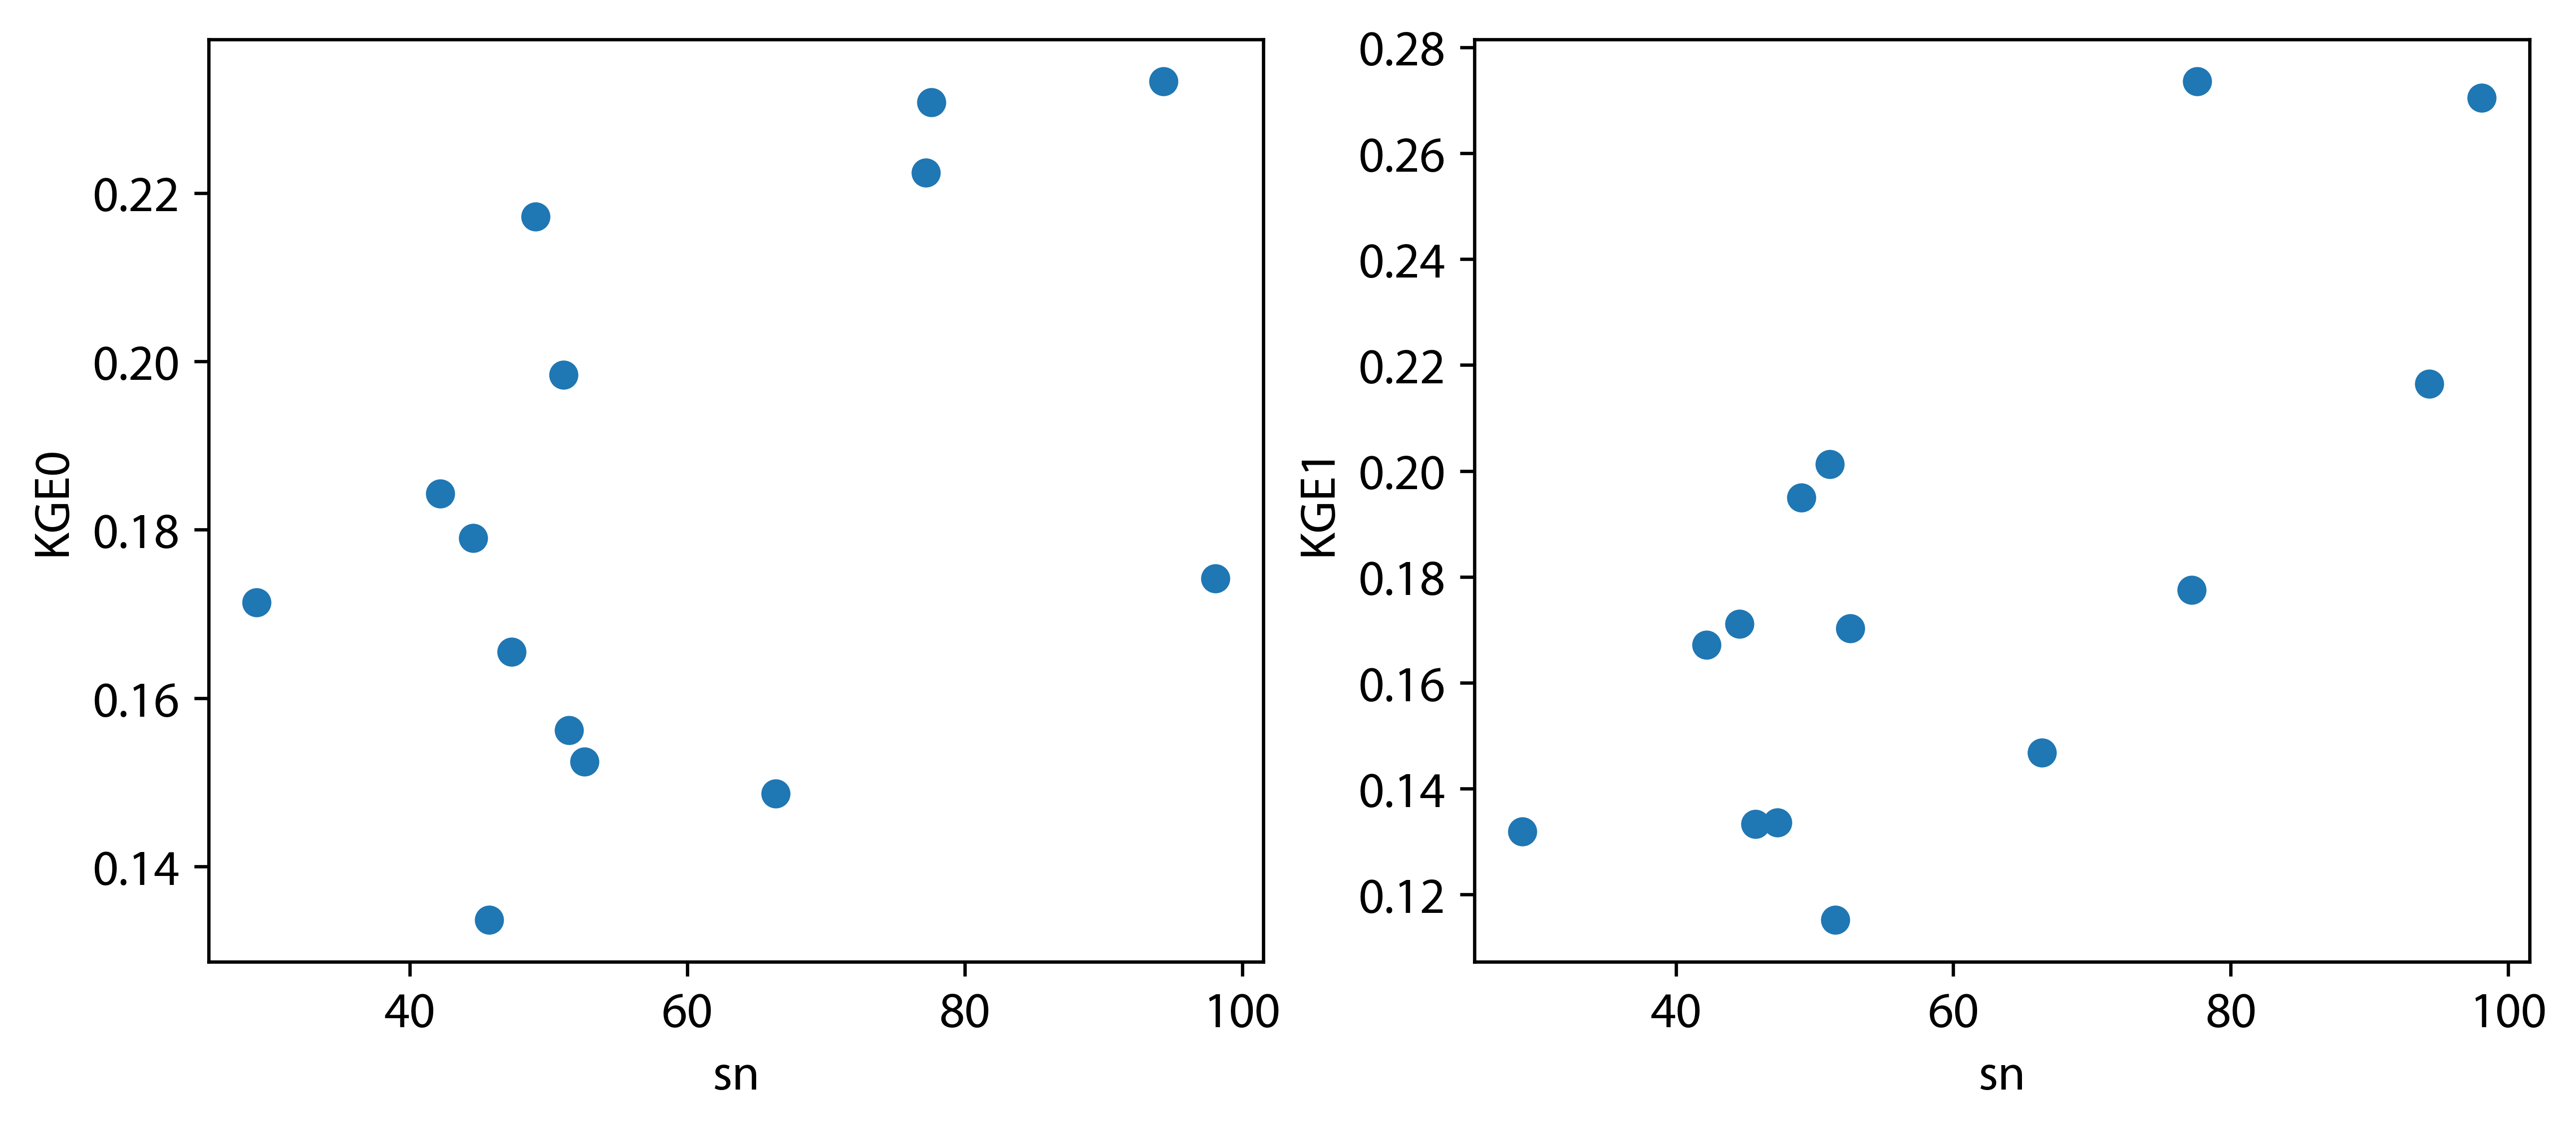

In [30]:
tmp = gp_interpolator(P = sim_idx.shape[0])
sn = np.zeros((14, ))
for i in range(12):
    tmp.read_rainfall(rain_obs[5::12, :], wrf_sta[5::12, :])
    tmp.sn_converge()
    sn = sn + 1 / 12 * tmp.sn

kge1_sta_mean = np.mean(kge1, axis = 0).squeeze()
kge0_sta_mean = np.mean(kge0, axis = 0).squeeze()
kge1_sta_std = np.std(kge1, axis = 0, ddof=1).squeeze()
kge0_sta_std = np.std(kge0, axis = 0, ddof=1).squeeze()
kge1_sta_max = np.max(kge1, axis = 0).squeeze()
kge0_sta_max = np.max(kge0, axis = 0).squeeze()

# # plot scatter plot of kge0 vs kge1, the color is associated with sn
# # add colorbar of values of sn
# fig, ax = plt.subplots(1, 1, figsize = (7, 5))
# sc = ax.scatter(kge0_sta_mean, kge1_sta_mean, c = sn, cmap = 'viridis')
# fig.colorbar(sc, ax = ax)
# ax.set_xlabel('KGE0')
# ax.set_ylabel('KGE1')

# fig, ax = plt.subplots(1, 1, figsize = (7, 5))
# sc = ax.scatter(-kge0_sta_mean + kge1_sta_mean, sn)


# plot scatter plot of kge0 vs kge1, the color is associated with sn
# add colorbar of values of sn
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].scatter(sn, kge0_sta_std)
ax[0].set_ylabel('KGE0')
ax[0].set_xlabel('sn')
ax[1].scatter(sn, kge1_sta_std)
ax[1].set_ylabel('KGE1')
ax[1].set_xlabel('sn')


<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not known>
<urlopen error [Errno -2] Name or service not 

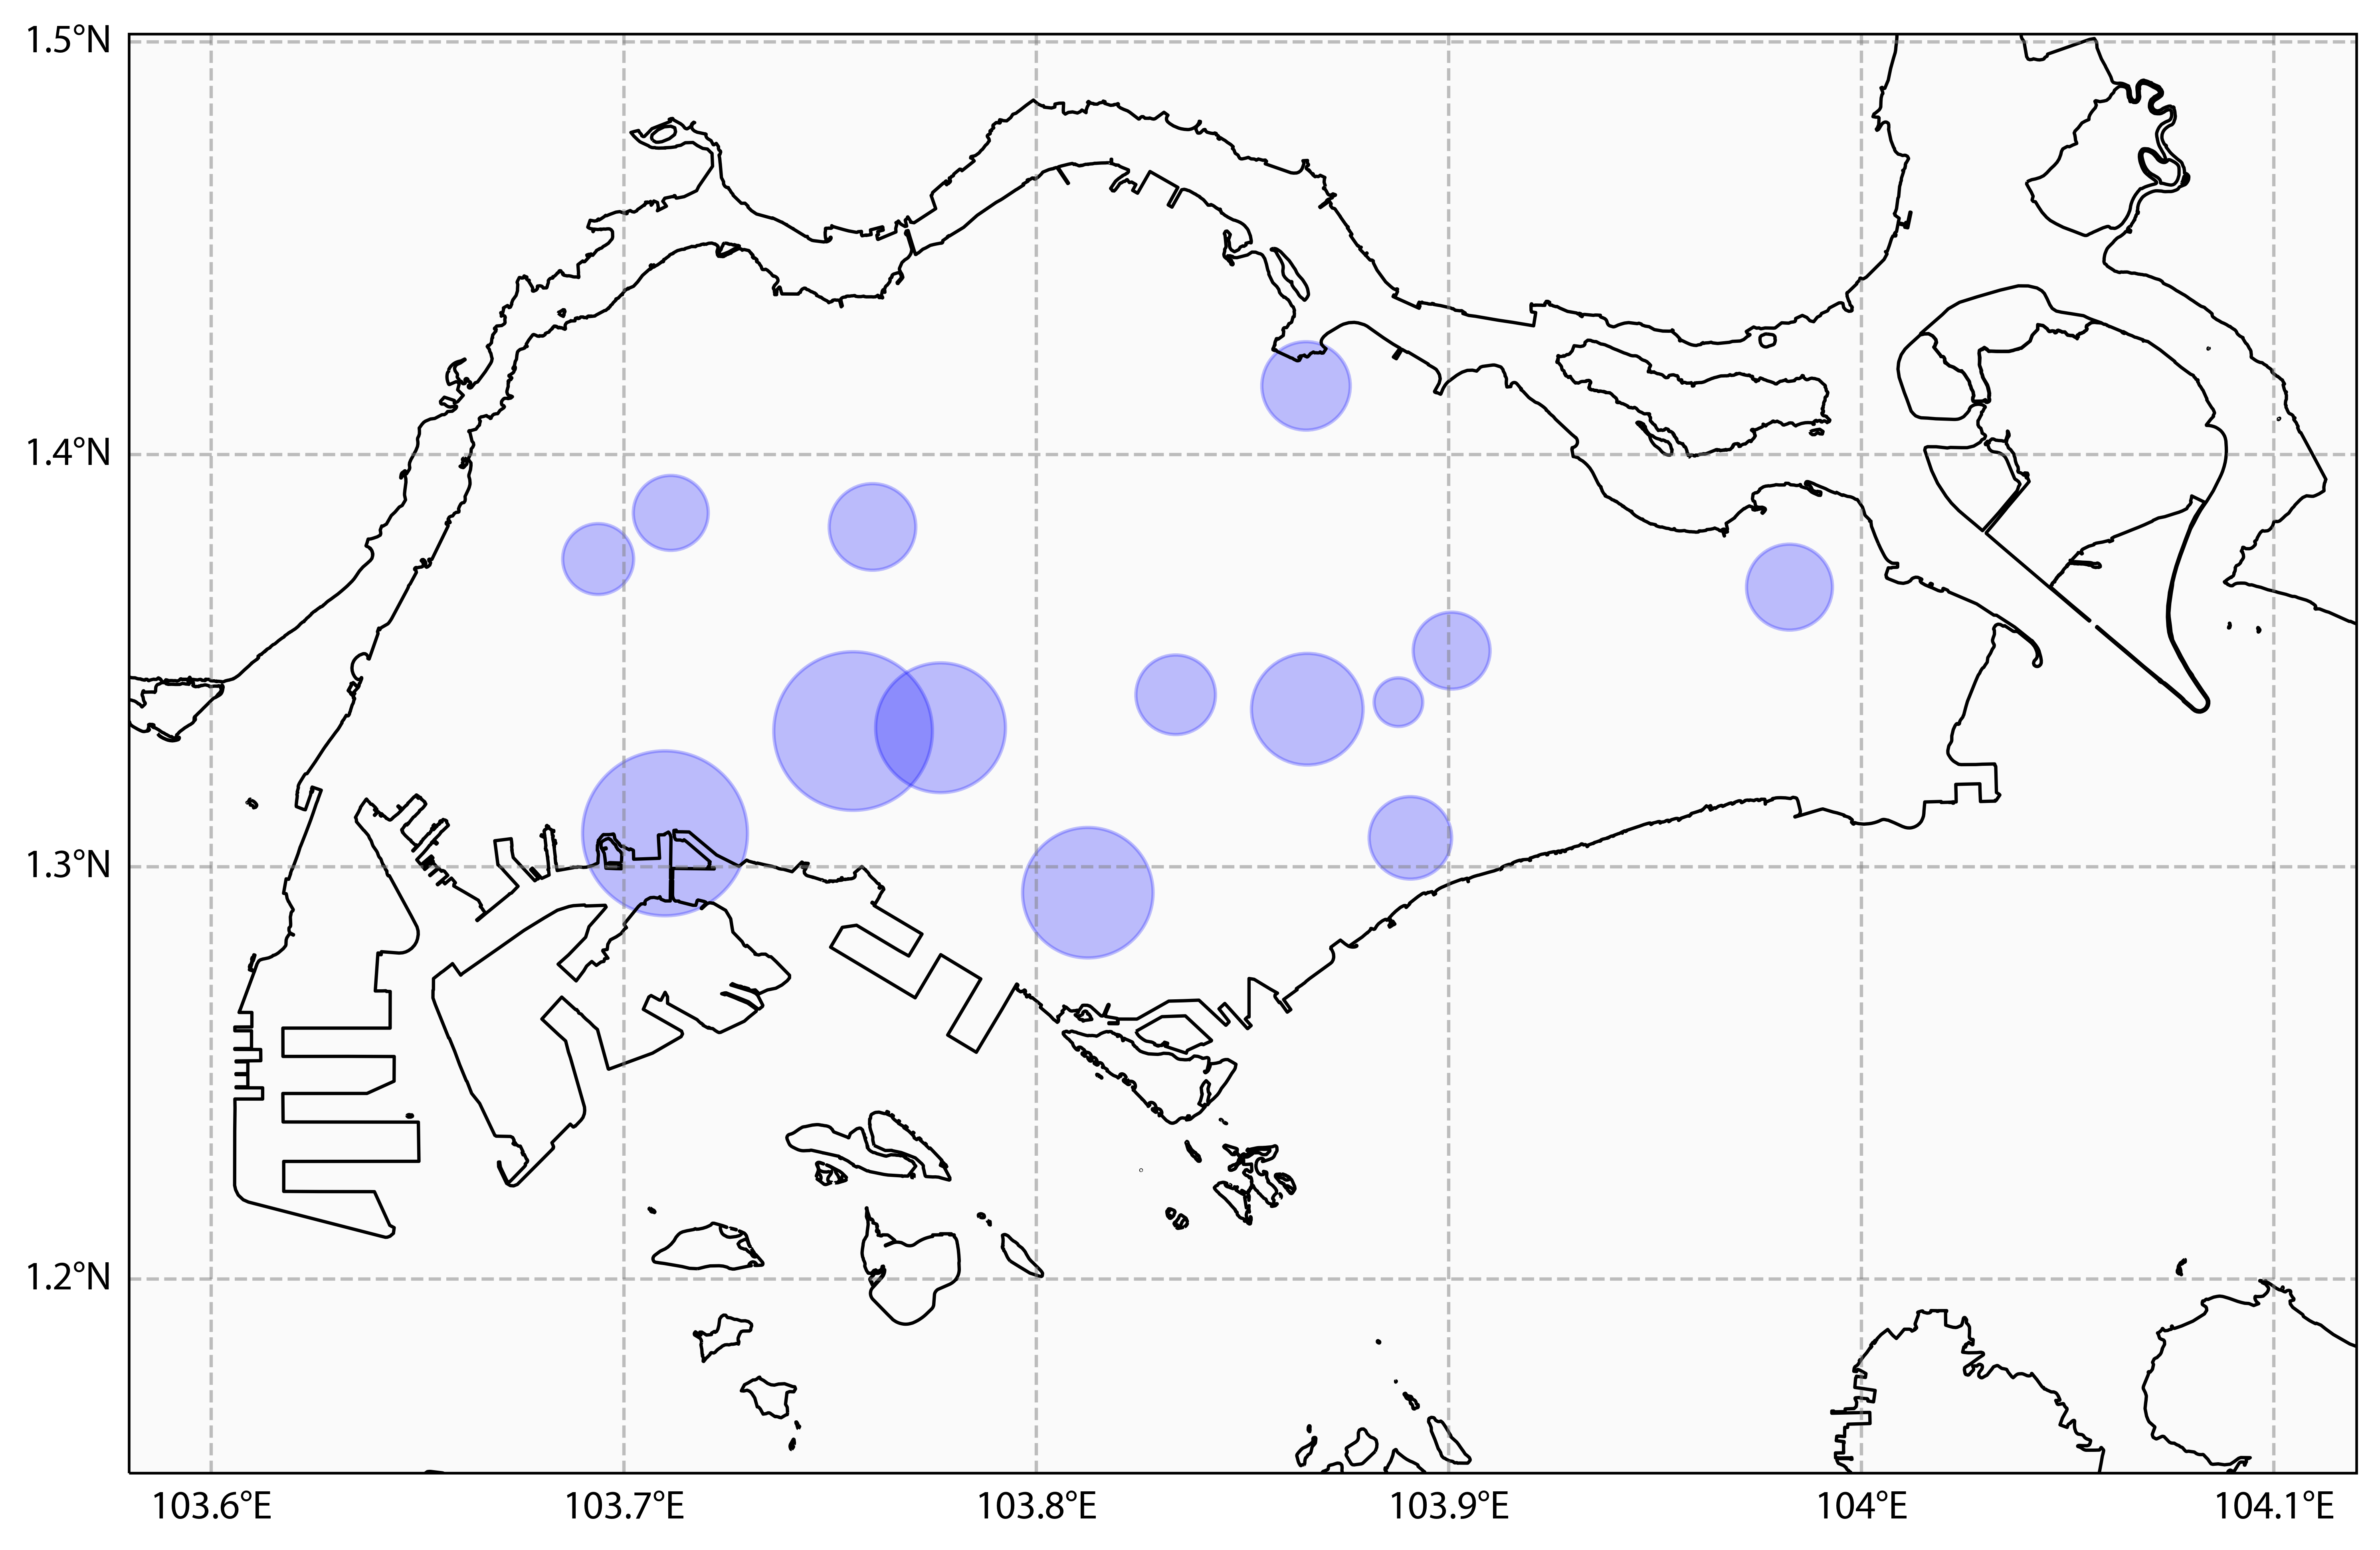

In [39]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[12,8], subplot_kw={'projection': crs.PlateCarree()})

max_radius = 0.02  # Max circle radius in degrees

tiler = Stamen('terrain-background')
mercator = tiler.crs
ax.add_image(tiler, 8)  # 8 is the zoom level, adjust as necessary for detail


coastline.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
ax.set_extent([103.58, 104.12, 1.153, 1.502], crs=crs.PlateCarree())
gl = ax.gridlines(crs=crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([103.5, 103.6, 103.7, 103.8, 103.9, 104.0, 104.1])
gl.ylocator = mticker.FixedLocator([1.1, 1.2, 1.3, 1.4, 1.5])


# plot the station locations as circles per the location info stored in a 2d array sta_loc of size P by 2
# the radius of the circles is proportional to the value of sn
for loc, tsn in zip(sta_loc, sn):
    radius = (tsn / max(sn)) * max_radius  # Scale radius
    circle = Circle(xy=(loc[0], loc[1]), radius=radius, color='blue', alpha=0.25, transform=crs.PlateCarree())
    ax.add_patch(circle)


<urlopen error [Errno -2] Name or service not known>


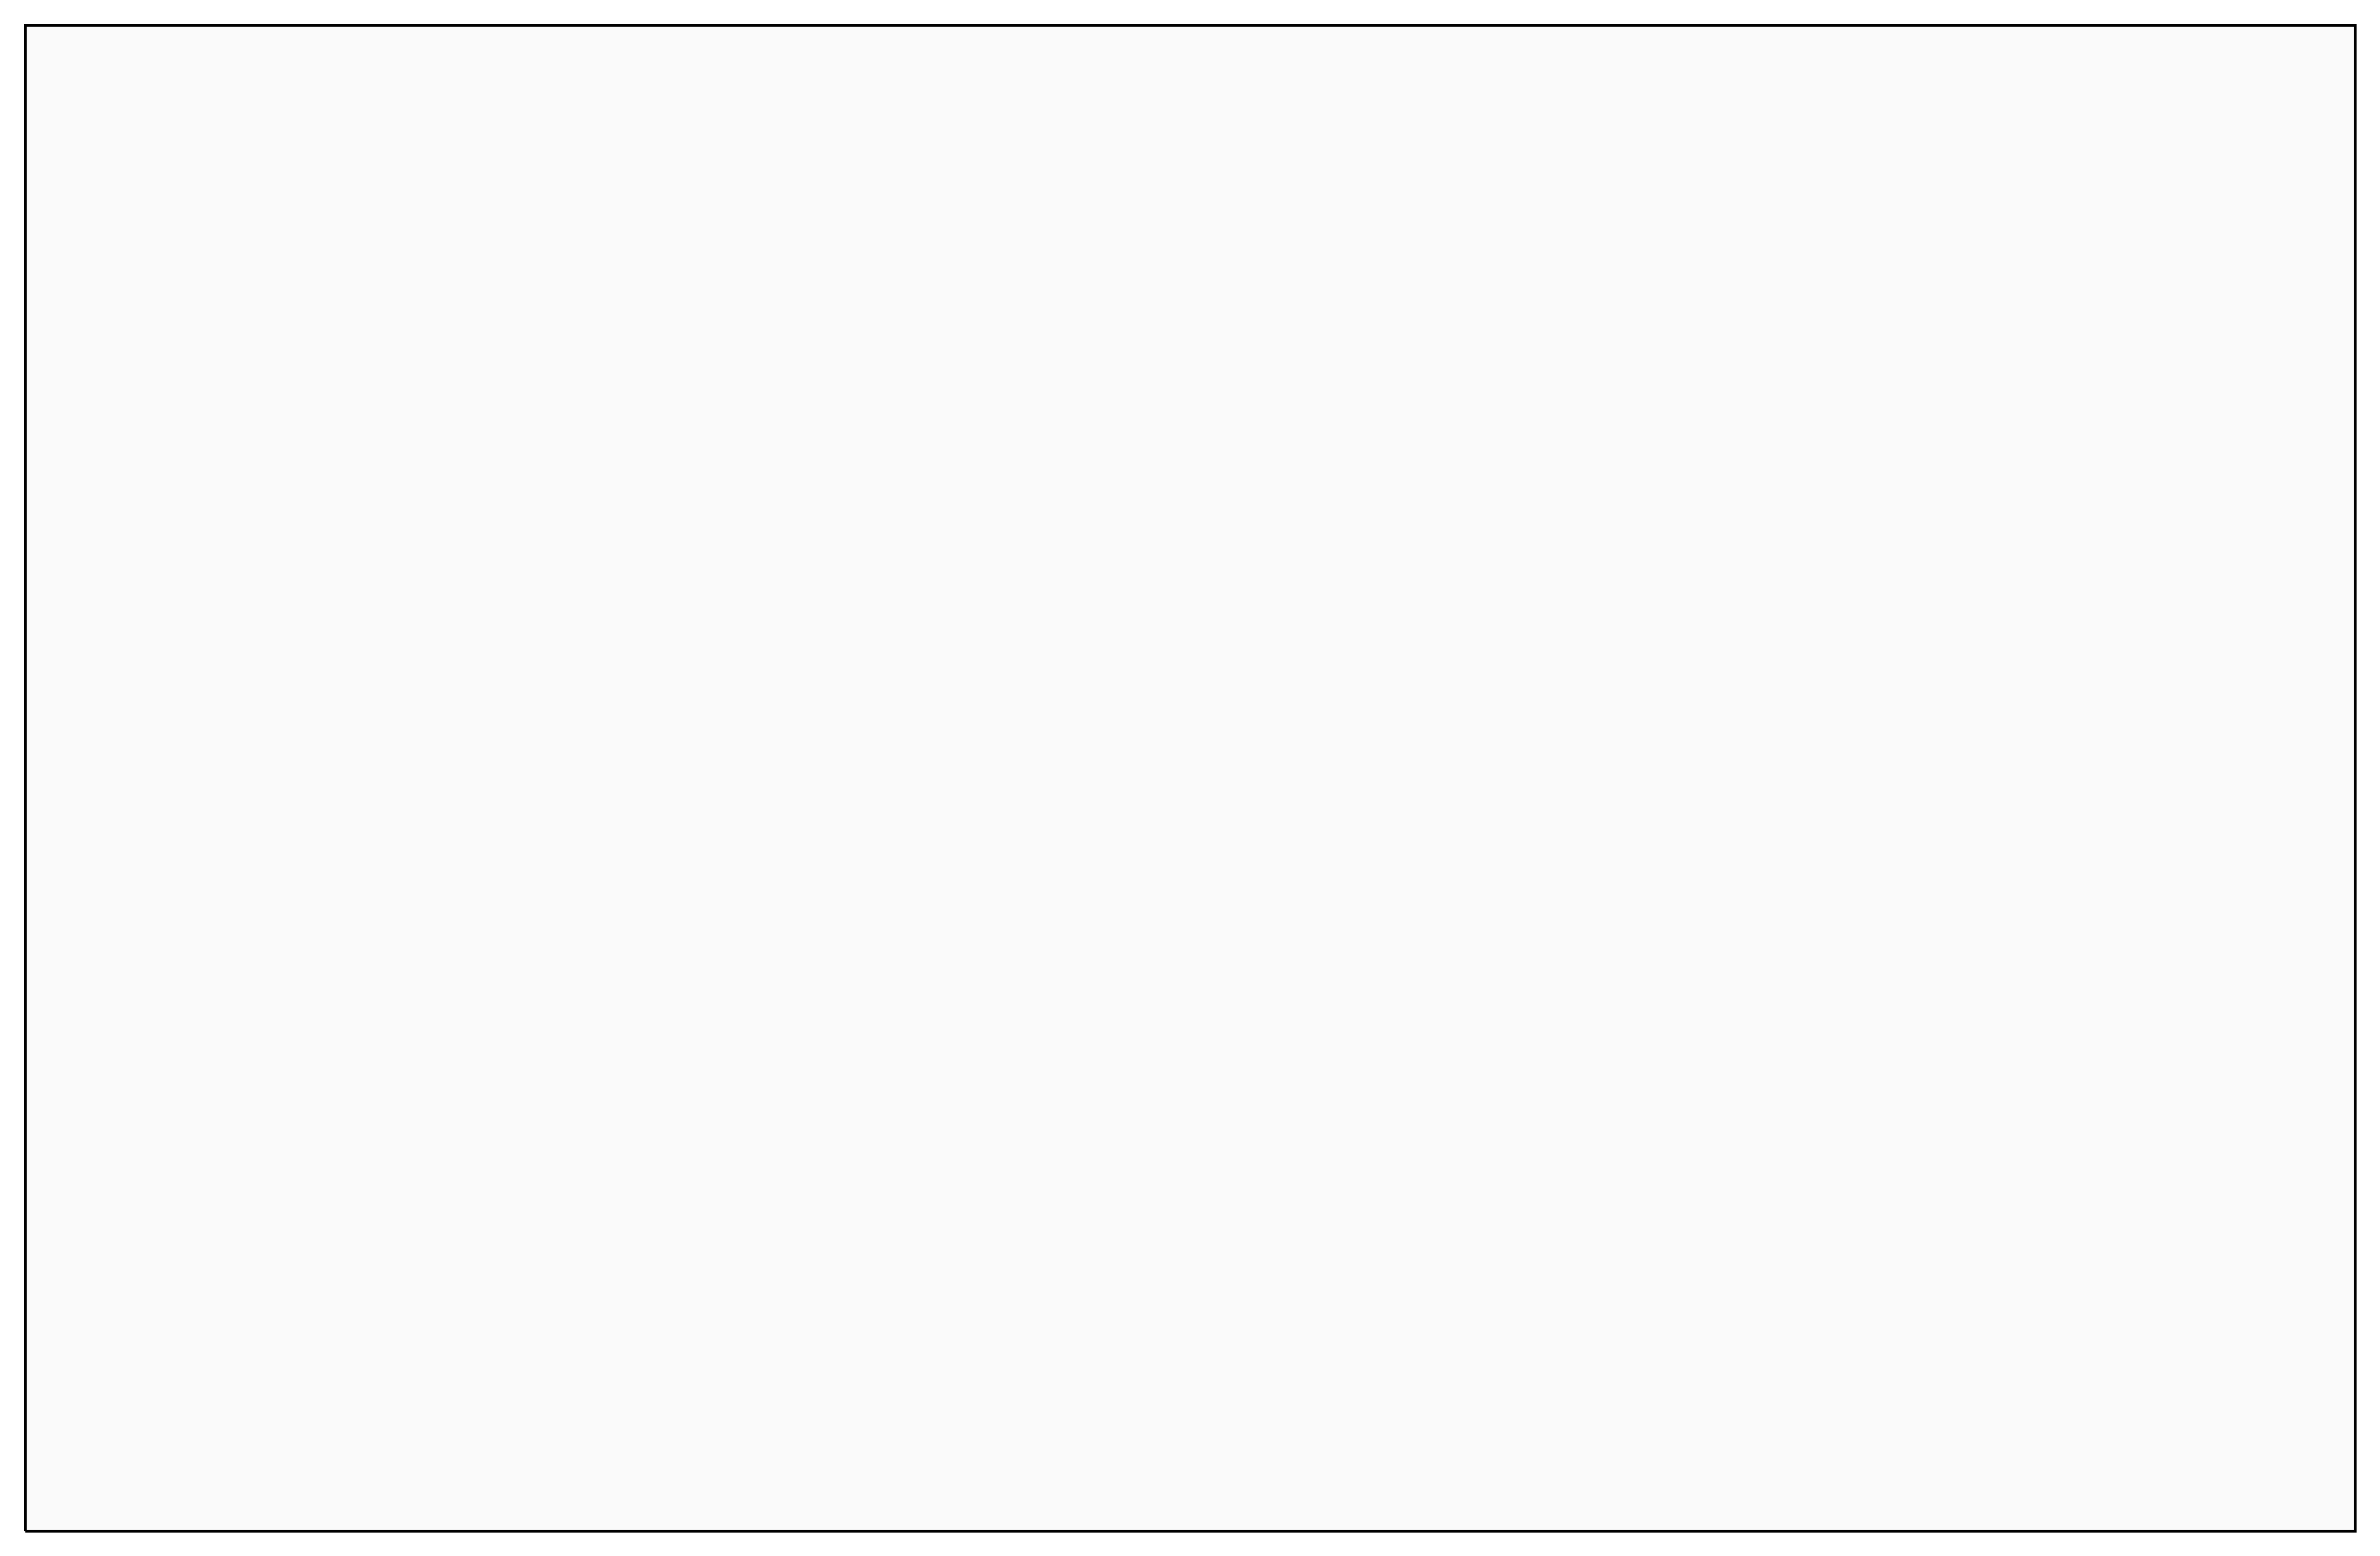

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as crs
from cartopy.io.img_tiles import Stamen
from matplotlib.patches import Circle

# Define the tile imagery
tiler = Stamen('terrain-background')
mercator = tiler.crs

# Example data setup
sta_loc = np.array([
    [103.85, 1.3], [103.9, 1.35], [103.95, 1.32], [104.0, 1.29], [103.87, 1.28],
    [103.82, 1.25], [103.88, 1.35], [103.85, 1.4], [103.9, 1.45], [103.96, 1.35],
    [104.02, 1.25], [104.06, 1.3], [104.1, 1.35], [104.04, 1.4]
])
sn = np.random.rand(14) * 10  # Random 'sn' values, replace with your actual data
max_radius = 0.02  # Max circle radius in degrees

# Create the figure and axis with the specified projection
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[12,8], subplot_kw={'projection': mercator})
ax.set_extent([103.58, 104.12, 1.153, 1.502], crs=mercator)

# Add the tile layer
ax.add_image(tiler, 8)  # 8 is the zoom level, adjust as necessary for detail

# Add gridlines
gl = ax.gridlines(crs=crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([103.5, 103.6, 103.7, 103.8, 103.9, 104.0, 104.1])
gl.ylocator = mticker.FixedLocator([1.1, 1.2, 1.3, 1.4, 1.5])

# Plot the station locations as circles
for loc, tsn in zip(sta_loc, sn):
    radius = (tsn / max(sn)) * max_radius  # Scale radius based on the 'sn' value
    circle = Circle(xy=(loc[0], loc[1]), radius=radius, color='blue', alpha=0.5, transform=crs.PlateCarree())
    ax.add_patch(circle)

plt.show()
